In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
script_dir = os.getcwd()

from sde.SDE_AM_lib import (
    SDEAMTrain,
    NNHyperparameters,
    theoretical_mean_loss_estimate
)

from sde.experiment_reports import (
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    histogram_data,
    plot_histogram
)

%load_ext autoreload
%autoreload 2

2025-01-12 01:22:47.791051: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 01:22:47.795144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-12 01:22:47.795157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# notebook parameters
random_seed = 2
step_size = 1e-2
n_pts = 10000

n_dimensions = 1

In [3]:
# EXAMPLE 1
def true_drift(x):
    return -(4*x**3 - 2*4*x+3)/2


def true_diffusivity(x):
    return (1e-1*x+1)*0.5


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

xlim = [-2, 2]

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[0], high=xlim[1], n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

data shape (10000, 1)


In [4]:
# network parameters
validation_split = .1
AM_validation_split = .1

drift_param = NNHyperparameters(K=2**6, 
                                M_min=20,
                                M_max=300,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [5]:
TMLE = theoretical_mean_loss_estimate()
mean_loss, SD, SD_val = TMLE.get_TMLE(true_diffusivity, n_dimensions, n_pts, validation_split, xlim, step_size)
print('Theoretical mean min loss:', mean_loss)
print('Loss standard deviation:', SD)
print('Validation loss standard deviation:', SD_val)

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "TMLE ex3 - 1d sde-cubic.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_loss}\n")


Theoretical mean min loss: 0.012817769377195587
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


In [6]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEAMTrain(n_dimensions=n_dimensions, diff_type="diagonal", resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusivity, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, AM_validation_split=AM_validation_split, plot=False)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

drift epoch: 47
diff epoch: 20
Observed loss: 0.0046887677821825235
Observed validation loss: -0.007601643856337992
 Training time: 4.000656843185425


2025-01-12 01:22:57.027897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-12 01:22:57.028017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-01-12 01:22:57.028066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-01-12 01:22:57.072999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2025-01-12 01:22:57.073075: W tensorflow/stream_executor/platform/default/dso_loader

/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/douglaoj/miniconda

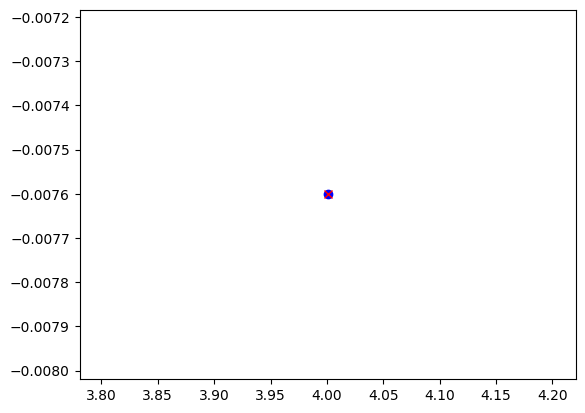

In [7]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "ex3 - 1d sde-cubic wo resampling data.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")


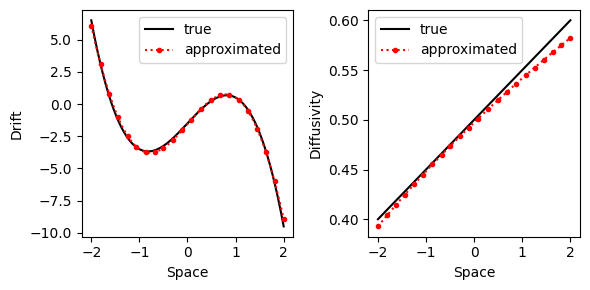

In [8]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(SAT.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, "ex3 - 1d-cubic sde")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

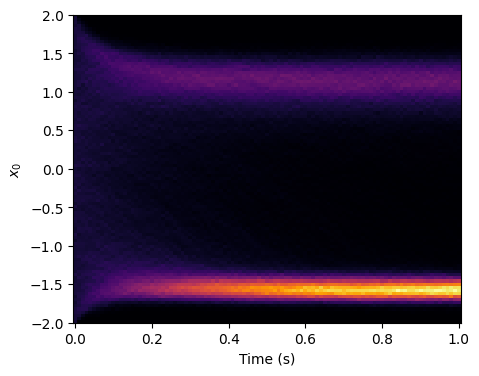

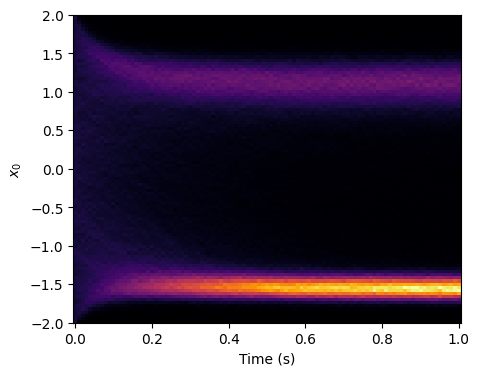

In [10]:
time = 1
true_paths = histogram_data(true_drift_diffusivity, xlim[0], xlim[1], step_size, time, n_dimensions)
ARFF_paths = histogram_data(SAT.drift_diffusivity, xlim[0], xlim[1], step_size, time, n_dimensions)

plot_histogram(true_paths, xlim[0], xlim[1], step_size)
plot_histogram(ARFF_paths, xlim[0], xlim[1], step_size)

# output_dir = os.path.join(script_dir, 'histogram_data')

# output_path_true = os.path.join(output_dir, "ex3 - 1d sde-cubic data.txt")
# with open(output_path_true, 'w') as file:
#     file.write(f"{step_size},{xlim[0]},{xlim[1]}\n")

# output_path_true = os.path.join(output_dir, "ex3 - 1d sde-cubic true.npy")
# np.save(output_path_true, true_paths)

# output_path_ARFF = os.path.join(output_dir, "ex3 - 1d sde-cubic ARFF.npy")
# np.save(output_path_ARFF, ARFF_paths)

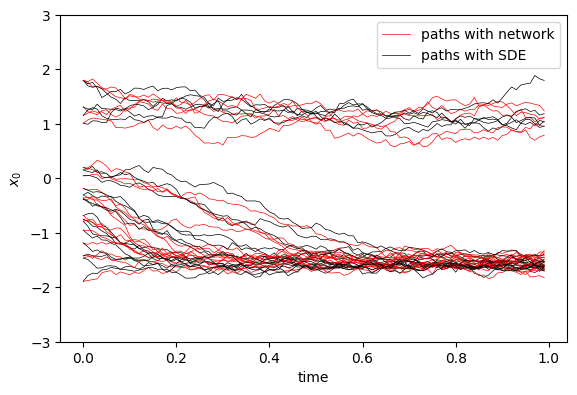

In [40]:
T_steps = 100
N_iterates = 20

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(SAT.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([-3,3])
plt.gca().set_ylabel(r"$x_0$");

# plt.savefig(r"C:\Users\owen\Documents\jobs\KAUST\work\SDE AM project\project write up\saved plots\ex3 - 1d paths.png")